In [1]:
from typing import List, Tuple, Iterable
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit.quantum_info import SparsePauliOp
import math
from typing import *
import random
import itertools

In [7]:
class RBM():

    """
    A bound-based restricted quantum Boltzmann Machine based on "Quantum Boltzmann Machine" by Amin et al. 
    """

    def __init__(self, **kwargs) -> None:
        """
        Initialize the RBM model with various parameters.

        Parameters
        ----------
        numInputNodes: int, required
            The number of input nodes in the visible layer.
        numOutputNodes: int, required
            The number of output nodes in the visible layer. 
        numHiddenNodes: int, required
            The number of hidden nodes for for the hidden layer.
        beta: float, optional
            Specifies the inverse of the temperature. Default is 100.
        vvEdges: bool, optional
            Set to True to add edges between visible nodes (this is a semi-restricted Boltzmann Machine). Default is false.
        qrbm: bool, optional
            Set to True to add transverse (gamma) terms to Hamiltonian.
        trainTransverse: bool, optional
            Set to True to attempt to perform gradient descent on transverse (gamma) biases.
        """

        
        if not kwargs.get('numInputNodes'):
            raise Exception('You must specify the number of input nodes for the RBM.')
        else:
            numInputNodes = kwargs.get('numInputNodes')
            self.inputNodes = [i for i in range(numInputNodes)]

        
        if not kwargs.get('numOutputNodes'):
            raise Exception('You must specify the number of output nodes for the RBM.')
        else:
            numOutputNodes = kwargs.get('numOutputNodes')
            self.outputNodes = [i for i in range(numInputNodes, numInputNodes + numOutputNodes)]


        if not kwargs.get('numHiddenNodes'):
            raise Exception('You must specify the number of hidden nodes for the RBM.')
        else:
            numHiddenNodes = kwargs.get('numHiddenNodes')
            self.hiddenNodes = [i for i in range(numInputNodes + numOutputNodes, numOutputNodes + numInputNodes + numHiddenNodes)]

        
        self.visibleNodes = self.inputNodes + self.outputNodes
        self.nodes = self.inputNodes + self.outputNodes + self.hiddenNodes
        self.numNodes = len(self.nodes)

        
        if kwargs.get('vvEdges', False):
            self.edges = self.HVandVV()
        else:
            self.edges = self.HV()
            

        self.edgeWeights = {edge: np.random.normal(loc=0, scale=.01) for edge in self.edges}
        self.zNodeWeights = list(np.random.normal(loc=0, scale=.01, size=self.numNodes))


        self.beta = kwargs.get('beta', 100)
        self.qrbm = kwargs.get('qrbm', False)
        self.trainTransverse = kwargs.get('trainTransverse', False)
        
        if self.qrbm:
            self.xNodeWeights = list(np.random.normal(loc=0, scale=.01, size=self.numNodes))
        else:
            self.xNodeWeights = None

        if self.trainTransverse and not self.qrbm:
            raise Exception("Training transverse terms requires qrbm to be True.")


    def clampedAvgXweight(self, node: int, visibleStates: List[Tuple[int]], PvData: Dict[Tuple[int], float]) -> int:
        """
        Positive phase for x gradient step.
        """
        total = 0

        for v in visibleStates:

            H = self.getClampedHamiltonian(v)
            p = self.getDensityMatrix(H)
    
            sigmaX = ['I'] * self.numNodes
            sigmaX[node] = 'X'
            sigmaX = ''.join(reversed(sigmaX))
            sigmaX = SparsePauliOp.from_list([(sigmaX, 1)])

            if node in self.visibleNodes and p.expectation_value(sigmaX).real != 0:
                raise Exception(f"Positive phase for sigmaX_vis is not zero. Its value is {p.expectation_value(sigmaX).real}")

            total += PvData[v] * p.expectation_value(sigmaX).real 

        return total
   

    def unclampedAvgXweight(self, node: int, unclampedP: qiskit.quantum_info.DensityMatrix) -> int:
        """
        Negative phase for x gradient step.
        """
        sigmaX = ['I'] * self.numNodes
        sigmaX[node] = 'X'
        sigmaX = ''.join(reversed(sigmaX))
        sigmaX = SparsePauliOp.from_list([(sigmaX, 1)])

        return unclampedP.expectation_value(sigmaX).real


    def b_i_eff(self, node: int, v: List[int]) -> int:
        """
        Calculates the b_i_eff value.

        (Line after equation 33)
        """
        if node not in self.hiddenNodes:
            raise Exception("This function should only be passed hidden nodes.")

        wvSum = self.zNodeWeights[node]
        for edge in self.edges:
            n1, n2 = edge
            if node == n1 or node == n2:
                
                if n1 in self.visibleNodes and n2 in self.hiddenNodes:
                    wvSum += self.edgeWeights[edge] * v[n1]
                    
                elif n2 in self.visibleNodes and n1 in self.hiddenNodes:
                    wvSum += self.edgeWeights[edge] * v[n2]

        return wvSum


    def clampedAvgZweightHidden(self, node: int, v: List[int]) -> int:
        """
        Positive phase for z gradient step (only hidden nodes).
        """
        if node not in self.hiddenNodes:
            raise Exception("This function should only be passed hidden nodes.")

        if not self.qrbm:
            return math.tanh(self.b_i_eff(node, v) * self.beta)
        
        b_i_eff = self.b_i_eff(node, v) * self.beta
        gamma_i = self.xNodeWeights[node] * self.beta
        D_i = math.sqrt((gamma_i ** 2) + (b_i_eff ** 2))

        return (b_i_eff / D_i) * math.tanh(D_i)


    def clampedAvgZweight(self, node: int, visibleStates: List[Tuple[int]], PvData: Dict[Tuple[int], float]) -> int:
        """
        Positive phase for z gradient step.
        """
        total = 0

        for v in visibleStates:

            H = self.getClampedHamiltonian(v) 
            p = self.getDensityMatrix(H)

            sigmaZ = ['I'] * self.numNodes

            c=1
            if node in self.hiddenNodes:
                sigmaZ[node] = 'Z'
            else:
                c *= v[node]
            
            sigmaZ = ''.join(reversed(sigmaZ))
            sigmaZ = SparsePauliOp.from_list([(sigmaZ, c)])

            if node in self.hiddenNodes and not np.isclose(self.clampedAvgZweightHidden(node, v), p.expectation_value(sigmaZ).real):
                raise Exception(f"Long and short computations for sigmaZ_hidden do not match. They are {p.expectation_value(sigmaZ).real} and {self.clampedAvgZweightHidden(node, v)}, respectively.")
                
            total += PvData[v] * p.expectation_value(sigmaZ).real        

        return total


    def unclampedAvgZweight(self, node: int, unclampedP: qiskit.quantum_info.DensityMatrix) -> int:
        """
        Negative phase for z gradient step.
        """
        sigmaZ = ['I'] * self.numNodes
        sigmaZ[node] = 'Z'                
        sigmaZ = ''.join(reversed(sigmaZ))
        sigmaZ = SparsePauliOp.from_list([(sigmaZ, 1)])

        return unclampedP.expectation_value(sigmaZ).real        


    def clampedAvgEdgeWeight(self, edge: Tuple[int, int], visibleStates: List[Tuple[int]], PvData: Dict[Tuple[int], float]) -> int:
        """
        Positive phase for edge gradident step.
        """
        total = 0

        for v in visibleStates:

            H = self.getClampedHamiltonian(v)
            p = self.getDensityMatrix(H)

            n1, n2 = edge
            doubleSigmaZ = ['I'] * self.numNodes
            
            c = 1
            
            if n1 in self.hiddenNodes:
                doubleSigmaZ[n1] = 'Z'
            else:
                c *= v[n1]
                
            if n2 in self.hiddenNodes:
                doubleSigmaZ[n2] = 'Z'
            else:
                c *= v[n2]

            doubleSigmaZ = ''.join(reversed(doubleSigmaZ))
            doubleSigmaZ = SparsePauliOp.from_list([(doubleSigmaZ, c)])
            total += PvData[v] * p.expectation_value(doubleSigmaZ).real

        return total


    def unclampedAvgEdgeWeight(self, edge: Tuple[int, int], unclampedP: qiskit.quantum_info.DensityMatrix) -> int:
        """
        Negative phase for edge gradient step.
        """      
        n1, n2 = edge
        doubleSigmaZ = ['I'] * self.numNodes       
        doubleSigmaZ[n1] = 'Z'
        doubleSigmaZ[n2] = 'Z'        
        doubleSigmaZ = ''.join(reversed(doubleSigmaZ))
        doubleSigmaZ = SparsePauliOp.from_list([(doubleSigmaZ, 1)])
        
        return unclampedP.expectation_value(doubleSigmaZ).real


    def getDensityMatrix(self, H: SparsePauliOp) -> qiskit.quantum_info.DensityMatrix:
        """
        Returns the density matrix given any Hamiltonian (clamped or unclamped).
        (Equation 12)
        """
    
        eToNegH = scipy.linalg.expm((-H * self.beta).to_matrix())
        partitionFunction = np.trace(eToNegH)
        p = qiskit.quantum_info.DensityMatrix(eToNegH / partitionFunction)
        
        return p


    def getClampedHamiltonian(self, v: List[int]) -> SparsePauliOp:
        """
        Returns the clamped Hamiltonian for an RBM. If qrbm, then sigmaX and sigmaZ terms are included for 
        each node, otherwise just sigmaZ terms are included.
        
        (Equation 33)
        """

        data = []

        for hiddenNode in self.hiddenNodes:
            sigmaZ  = ['I'] * self.numNodes
            sigmaZ[hiddenNode] = 'Z'
            data.append((''.join(reversed(sigmaZ)), -1 * self.b_i_eff(hiddenNode, v)))
            
        if self.qrbm:
            for hiddenNode in self.hiddenNodes:
                sigmaX  = ['I'] * self.numNodes
                sigmaX[hiddenNode] = 'X'
                data.append((''.join(reversed(sigmaX)), -1 * self.xNodeWeights[hiddenNode]))

        return SparsePauliOp.from_list(data)


    def getUnclampedHamiltonian(self) -> SparsePauliOp:
        """
        Returns the unclamped Hamiltonian for an RBM. If qrbm, then sigmaX and sigmaZ terms are included for 
        each node, otherwise just sigmaZ terms are included.
        
        (Equation 16)
        """
    
        data = []
        
        for node in self.nodes:
            sigmaZ  = ['I'] * self.numNodes
            sigmaZ[node] = 'Z'
            data.append((''.join(reversed(sigmaZ)), -1 * self.zNodeWeights[node]))

    
        if self.qrbm:
            for node in self.nodes:
                sigmaX  = ['I'] * self.numNodes
                sigmaX[node] = 'X'
                data.append((''.join(reversed(sigmaX)), -1 * self.xNodeWeights[node]))
        
        for edge in self.edges:
            n1, n2 = edge
            doubleSigmaZ = ['I'] * self.numNodes
            doubleSigmaZ[n1] = 'Z'
            doubleSigmaZ[n2] = 'Z'
            data.append((''.join(reversed(doubleSigmaZ)), -1 * self.edgeWeights[edge]))


        return SparsePauliOp.from_list(data)


    def logLikelihood(self, PvData: dict[Tuple[int], float], PvModel: dict[Tuple[int], float], eps: float) -> List[Tuple[int, complex]]:
        """
        Computes logLikelihood of the data and model distributions.

        (Equation 3)
        """
        llh = 0

        for state in PvModel.keys():
            if PvData[state] != 0:
                modelVal = eps if PvModel[state] == 0 else PvModel[state]
                llh -= PvData[state] * np.log(modelVal)

        return llh


    def updateBeta(self, epoch: int, initialBeta: float, finalBeta: float, tempSchedule: str, betaGrowthEpochs: int) -> None:
        """
        Used to update beta based on the temperature schedule. 
        """
        if tempSchedule == "linear":
            self.beta = finalBeta + (((finalBeta - initialBeta) / (betaGrowthEpochs)) * (epoch - betaGrowthEpochs))
            
        elif tempSchedule == "exponential":
            self.beta = finalBeta - ((finalBeta - initialBeta) * (math.exp((-1 * epoch) / (betaGrowthEpochs / 4)))) # 4 is a hyperparameter


    def train(self, **kwargs) -> None:
        """
        Train the RBM.

        Parameters
        ----------
        data: list of tuples or dictionary in PvData form (v, prob), required
            The data distribution to be learned by the RBM.
        optimizer: str in ["adam", ], optional
            Specify an optimizer. Default is "adam".
        alpha: float, optional
            Specify the learning rate / alpha hyperparamter for Adam. Default is .001.
        b1 : float, optional
            Exponential decay rate for the first moment estimates (beta1) for ADAM optimizer. Default is 0.9.
        b2 : float, optional
            Exponential decay rate for the second moment estimates (beta2) for ADAM optimizer. Default is 0.999.
        epsilon : float, optional
            Small constant for numerical stability in ADAM optimizer. Default is 1e-8.
        epochs: int, optional
            Specify the number of epochs to train. Default is 200.
        tempSchedule: str in ["linear", "exponential"], optional
            Specify a temperature schedule type. Default is None.
        finalBeta: float, optional
            Specify a final beta value (only to be used with a tempSchedule). Default is None.
        betaGrowthEpochs: int, optional
            How many epochs for which beta should change (starts from beginning of training). Default is None.
        verbose: bool, optional
            Include many print statements if True. Default is True.
        infoEveryNepochs: int, optional
            If verbose, print information every N epochs. Default is 1.
        """
        optimizer = kwargs.get('optimizer', "adam")
        optimizer = optimizer.lower() if optimizer else optimizer
        alpha = kwargs.get('alpha', .001)
        b1 = kwargs.get('b1', .9)
        b2 = kwargs.get('b2', .999)
        epsilon = kwargs.get('epsilon', 1e-8)
        epochs = kwargs.get('epochs', 200)
        tempSchedule = kwargs.get('tempSchedule', None)
        tempSchedule = tempSchedule.lower() if tempSchedule else tempSchedule
        finalBeta = kwargs.get('finalBeta', None)
        betaGrowthEpochs = kwargs.get('betaGrowthEpochs', None)
        verbose = kwargs.get('verbose', True)
        infoEveryNepochs = kwargs.get('infoEveryNepochs', 1)

        
        if tempSchedule:
            if not finalBeta:
                raise Exception("Specify a final value for beta.")

            if tempSchedule not in ["linear", "exponential"]:
                raise Exception("Type of temp schedule not found.")
            
            if not betaGrowthEpochs:
                raise Exception("Specify how long beta should grow for (the first n epochs).")
     
            if betaGrowthEpochs > epochs:
                raise Exception("betaGrowthEpochs must be less than or equal to epochs.")

        if not tempSchedule and (finalBeta or betaGrowthEpochs):
            raise Exception("finalBeta and betaGrowthEpochs each require a specified tempSchedule.")

        if optimizer:
            if optimizer not in ["adam"]:
                raise Exception("Optimizer not found")

        
        initialBeta = self.beta
        numHidden = len(self.hiddenNodes)
        numVisible = len(self.visibleNodes)
        PvData = self.getPvData(data)
        visibleStates = self.getAllStatesPlusMinus1(numVisible)
        zList = []
        edgeList = []
        xList = []
        dataDistribution = self.getPvData(data)

        if verbose:
            print("Initial z weights:", self.zNodeWeights)
            print("Initial edge weights:", self.edgeWeights)
            print("Initial x weights:", self.xNodeWeights)
            print("visibleStates:", visibleStates)

        self.drawQBM()


        #############################################################################################################

        llhList = []
        betaList = []
        
        m_z = [0] * self.numNodes
        v_z = [0] * self.numNodes

        m_edge = {edge: 0 for edge in self.edges}
        v_edge = {edge: 0 for edge in self.edges}

        m_x = [0] * self.numNodes
        v_x = [0] * self.numNodes

        # Iterate over the number of epochs
        for i in range(epochs):
        
            unclampedHamiltonian = self.getUnclampedHamiltonian()
            unclampedP = self.getDensityMatrix(unclampedHamiltonian)
            modelDistribution = self.getPvModel()
            llh = self.logLikelihood(dataDistribution, modelDistribution, 1e-11)
            llhList.append((i, llh))
            betaList.append((i,self.beta))

            
            if tempSchedule:
                if i <= betaGrowthEpochs:
                    self.updateBeta(i, initialBeta, finalBeta, tempSchedule, betaGrowthEpochs)

            if verbose and (i % infoEveryNepochs == 0):
                print("data:", dataDistribution)
                print("model:", modelDistribution)
                print("LLH:", llh)
                print("beta:", self.beta)
                print("EPOCH:", i)
                self.graphDistributions(dataDistribution, modelDistribution, True)

        
            newZweights = copy.copy(self.zNodeWeights)
            newEdgeWeights = copy.copy(self.edgeWeights)
            newXweights = copy.copy(self.xNodeWeights)
            
            #############################################################################################################

            # Z weights (b term)

            if not optimizer:
                for node in self.nodes:
                    positivePhase = self.clampedAvgZweight(node, visibleStates, PvData)
                    negativePhase = self.unclampedAvgZweight(node, unclampedP)
                    gradientStep = alpha * (positivePhase - negativePhase)
                    newZweights[node] += gradientStep
                    print(f"z gradient step for node {node}: {gradientStep}") if verbose else None
                    
            if optimizer == "adam":
                g = [0] * self.numNodes
                
                for node in self.nodes:
                    positivePhase = self.clampedAvgZweight(node, visibleStates, PvData)
                    negativePhase = self.unclampedAvgZweight(node, unclampedP)
                    gradientStep = positivePhase - negativePhase
                    g[node] = gradientStep
                    print(f"z gradient step for node {node}: {gradientStep}") if verbose else None
    
                m_z = [b1 * m_z[node] + (1 - b1) * g[node] for node in self.nodes]
                v_z = [b2 * v_z[node] + (1 - b2) * (g[node] ** 2) for node in self.nodes]
    
                mHat = [m_z[node] / (1 - (b1 ** (i + 1))) for node in self.nodes]
                vHat = [v_z[node] / (1 - (b2 ** (i + 1))) for node in self.nodes]
    
                adamTerm = [-1 * alpha * mHat[node] / (math.sqrt(vHat[node]) + epsilon) for node in self.nodes]
                
                for node in self.nodes:
                    newZweights[node] -= adamTerm[node]

            zList.append((i, newZweights))
                
            #############################################################################################################

            # Edge weights (w term)

            if not optimizer:
                for edge in self.edges:
                    positivePhase = self.clampedAvgEdgeWeight(edge, visibleStates, PvData)
                    negativePhase = self.unclampedAvgEdgeWeight(edge, unclampedP)
                    gradientStep = alpha * (positivePhase - negativePhase)
                    newEdgeWeights[edge] += gradientStep
                    print(f"edge graident step for edge {edge}: {gradientStep}") if verbose else None

            if optimizer == "adam":
                g = {edge: 0 for edge in self.edges}
    
                for edge in self.edges:
                    positivePhase = self.clampedAvgEdgeWeight(edge, visibleStates, PvData)
                    negativePhase = self.unclampedAvgEdgeWeight(edge, unclampedP)
                    gradientStep = positivePhase - negativePhase
                    g[edge] = gradientStep
                    print(f"edge graident step for edge {edge}: {gradientStep}") if verbose else None
    
                m_edge = {edge: b1 * m_edge[edge] + (1 - b1) * g[edge] for edge in self.edges}
                v_edge = {edge: b2 * v_edge[edge] + (1 - b2) * (g[edge] ** 2) for edge in self.edges}
    
                mHat_edge = {edge: m_edge[edge] / (1 - (b1 ** (i + 1))) for edge in self.edges}
                vHat_edge = {edge: v_edge[edge] / (1 - (b2 ** (i + 1))) for edge in self.edges}
    
                adamTerm = {edge: -1 * alpha * mHat_edge[edge] / (math.sqrt(vHat_edge[edge]) + epsilon) for edge in self.edges}

                for edge in self.edges:
                    newEdgeWeights[edge] -= adamTerm[edge]

            edgeList.append((i, newEdgeWeights))
            
            #############################################################################################################

            # x weights (gamma term)

            if self.trainTransverse:

                if not optimizer:
                    for node in self.nodes:
                        positivePhase = self.clampedAvgXweight(node, visibleStates, PvData)
                        negativePhase = self.unclampedAvgXweight(node, unclampedP)
                        gradientStep = alpha * (positivePhase - negativePhase)
                        newXweights[node] += gradientStep
                        print(f"x gradient step for node {node}: {gradientStep}") if verbose else None
                        
                if optimizer == "adam":
                    g = [0] * self.numNodes
                    
                    for node in self.nodes:
                        positivePhase = self.clampedAvgXweight(node, visibleStates, PvData)
                        negativePhase = self.unclampedAvgXweight(node, unclampedP)
                        gradientStep = positivePhase - negativePhase
                        g[node] = gradientStep
                        print(f"x gradient step for node {node}: {gradientStep}") if verbose else None
        
                    m_x = [b1 * m_x[node] + (1 - b1) * g[node] for node in self.nodes]
                    v_x = [b2 * v_x[node] + (1 - b2) * (g[node] ** 2) for node in self.nodes]
        
                    mHat = [m_x[node] / (1 - (b1 ** (i + 1))) for node in self.nodes]
                    vHat = [v_x[node] / (1 - (b2 ** (i + 1))) for node in self.nodes]
        
                    adamTerm = [-1 * alpha * mHat[node] / (math.sqrt(vHat[node]) + epsilon) for node in self.nodes]
                    
                    for node in self.nodes:
                        newXweights[node] -= adamTerm[node]

            if self.qrbm:
                xList.append((i, newXweights))

        
            #############################################################################################################

            self.zNodeWeights = newZweights
            self.edgeWeights = newEdgeWeights
            self.xNodeWeights = newXweights


        print("Results:")
        modelDistribution = self.getPvModel()
        self.graphDistributions(dataDistribution, modelDistribution, True)
        self.graphllhList(llhList)
        minLLH = min(llhList, key=lambda x: x[1])
        print("minLLH:", minLLH)

        if verbose:
            print("llhList:", llhList)
        
        self.graphBetaList(betaList)
        self.plotAbsoluteWeights(zList, edgeList, xList)

        #############################################################################################################


    def getPvData(self, data: List[Tuple[int]]) -> dict[Tuple[int], float]:
        """
        Returns the data's probability distribution.
        """
        if isinstance(data, dict):
            if len(data) != 2 ** len(self.visibleNodes):
                raise Exception("Please specify probabilities for all possible states v")
            else: 
                return data
    
        visibleStates = self.getAllStatesPlusMinus1(len(self.visibleNodes))
        counts  = {visibleState: 0 for visibleState in visibleStates}
    
        for d in data:
            counts[d] += 1
    
        numDatapoints = len(data)
        PvData = {visibleState: count / numDatapoints for visibleState, count in counts.items()}
    
        return PvData
        
    
    def getPvModel(self) -> Dict[Tuple[int], float]:
        """
        Returns the model's probability distribution.
        
        (Equation 13)
        """
        modelDistribution = {}
        H = self.getUnclampedHamiltonian()
        p = self.getDensityMatrix(H)
        visibleStates = self.getAllStatesPlusMinus1(len(self.visibleNodes))
        numVisibleStates = len(visibleStates)
        Ih = np.identity(int(math.pow(2, len(self.hiddenNodes))))

        for state in visibleStates:
            reverseStateIndex = -1
            for i, node in enumerate(state):
                if node == 1:
                    reverseStateIndex -= int(math.pow(2, i))
            bra = [0] * numVisibleStates
            bra[reverseStateIndex] = 1
            bra = np.matrix(bra).reshape(1, -1)
            ket = bra.H
            outerProd = ket @ bra
            lambdaV = np.kron(Ih, outerProd)

            Pv = np.trace(lambdaV.dot(p))
            modelDistribution[state] = Pv.real
            
        return modelDistribution


    def _autolabel(self, rects, ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    def graphDistributions(self, 
                           dataDistribution: Dict[Tuple[int], float], 
                           modelDistribution: Dict[Tuple[int], float], label: bool) -> None:
        """Graphs the data and model distributions for visual comparison."""
        # Extract keys and values
        labels = list(modelDistribution.keys())
        dataValues = [np.real(value) for value in dataDistribution.values()]
        modelValues = [np.real(value) for value in modelDistribution.values()]
        
        # Convert tuples to string for better visualization
        labelStrings = [str(label) for label in labels]
        
        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, modelValues, width, label='Model', color='blue')
        rects2 = ax.bar(x + width/2, dataValues, width, label='Data', color='orange')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Binary Strings')
        ax.set_ylabel('Probability')
        ax.set_title('Probability Distribution Comparison')
        ax.legend()

        if label:
            ax.set_xticks(x)
            ax.set_xticklabels(labelStrings)
            self._autolabel(rects1, ax)
            self._autolabel(rects2, ax)
        
        fig.tight_layout()
        plt.show()


    def plotAbsoluteWeights(self, zList: List[Tuple[int, List[float]]], edgeList: List[Tuple[int, Dict[Tuple[int, int], float]]], xList: List[Tuple[int, List[float]]]) -> None:
        """
        Plots the absolute values of each weight in a different color on one graph.
        """
        plt.figure(figsize=(12, 8))
        
        # Plot absolute Z weights
        if zList:
            epochs_z, z_weights = zip(*zList)
            for node_idx in range(len(z_weights[0])):
                node_weights = [abs(weights[node_idx]) for weights in z_weights]
                plt.plot(epochs_z, node_weights, marker='o', linestyle='-', label=f'Node {node_idx} Z-Weights')
    
        # Plot absolute Edge weights
        if edgeList:
            epochs_edge, edge_weights = zip(*edgeList)
            all_edges = set(edge for epoch_weights in edge_weights for edge in epoch_weights)
            for edge in all_edges:
                edge_weight_values = [abs(epoch_weights.get(edge, 0)) for epoch_weights in edge_weights]
                plt.plot(epochs_edge, edge_weight_values, marker='x', linestyle='--', label=f'Edge {edge} Weights')
    
        # Plot absolute X weights if xList is not empty
        if xList:
            epochs_x, x_weights = zip(*xList)
            for node_idx in range(len(x_weights[0])):
                node_weights = [abs(weights[node_idx]) for weights in x_weights]
                plt.plot(epochs_x, node_weights, marker='s', linestyle='-.', label=f'Node {node_idx} X-Weights')
    
        plt.xlabel('Epoch')
        plt.ylabel('Absolute Weight')
        plt.title('Absolute Weights by Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

    def graphllhList(self, llhList: List[Tuple[int, float]]) -> None:
        """
        Plots log-likelihood by epoch.
        """
        epochs, logLikelihoods = zip(*llhList)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, logLikelihoods, marker='o', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood by Epoch')
        plt.grid(True)
        plt.show()

    def graphBetaList(self, betaList: List[Tuple[int, float]]) -> None:
        """
        Plots log-likelihood by epoch.
        """
        epochs, betas = zip(*betaList)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, betas, marker='o', linestyle='-', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Beta')
        plt.title('Beta Values by Epoch')
        plt.grid(True)
        plt.show()
    
    
    def getAllStatesPlusMinus1(self, nodeCount: int) -> List[Tuple[int, int]]:
        """
        Returns all possible bitsrings for states up to ceil(log2(n)) with -1 and 1 (little endian).
    
        Example: getAllStatesPlusMinus1(3) -> [(-1,-1), (-1,1), (1,-1), (1,1)]
        """           
        return [tuple((1 if (i >> bit) & 1 else -1) for bit in reversed(range(nodeCount))) for i in range(2**nodeCount)]


    def HV(self) -> List[Tuple[int, int]]:
        """
        Creates a fully connected bipartite graph with edges from every visible node (input and output) to every hidden node.
    
        Edges are of the form (low, high); equivalently, (visible, hidden).
        """
        if len(self.nodes) != len(set(self.nodes)):
            raise Exception("Not all nodes are unique.")

        return [(min(visible, hidden), max(visible, hidden)) for visible in self.visibleNodes for hidden in self.hiddenNodes]


    def HVandVV(self) -> List[Tuple[int, int]]:
        """
        Gets the undirected edges for a graph that has all possible connections between (hidden, visible) nodes 
        and all possible connections between (visible, visible) nodes.
        """
        if len(self.nodes) != len(set(self.nodes)):
            raise Exception("Not all nodes are unique.")

        HV = self.HV()

        VV = list(itertools.combinations(self.visibleNodes, 2))

        return HV + VV
        

    def drawQBM(self) -> None:
        """
        Draws a QBM given a list of input nodes, output nodes, and hidden nodes.
        """
        # Initialize graph and add edges
        G = nx.Graph()
        G.add_edges_from(self.edges)
        
        # Assign colors
        color_map = {node: 'green' for node in self.inputNodes}
        color_map.update({node: 'blue' for node in self.outputNodes})
        color_map.update({node: 'red' for node in self.hiddenNodes})
        node_colors = [color_map[node] for node in G.nodes()]
        
        pos = {}
        
        # Set input node positions
        for i, node in enumerate(self.inputNodes):
            pos[node] = (0, i)
        
        # Set output node positions
        for i, node in enumerate(self.outputNodes):
            pos[node] = (0, len(self.inputNodes) + i)
            
        # Set hidden node positions
        visCount = len(self.visibleNodes)
        vertMidpt = visCount / 2
        
        for i, node in enumerate(self.hiddenNodes):
            pos[node] = (2, vertMidpt - (len(self.hiddenNodes) / 2) + i)
        
        # Draw the graph
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_color='white')

Results:


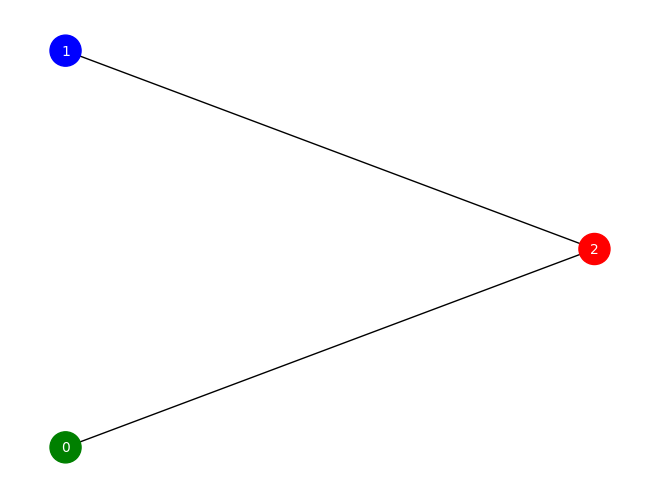

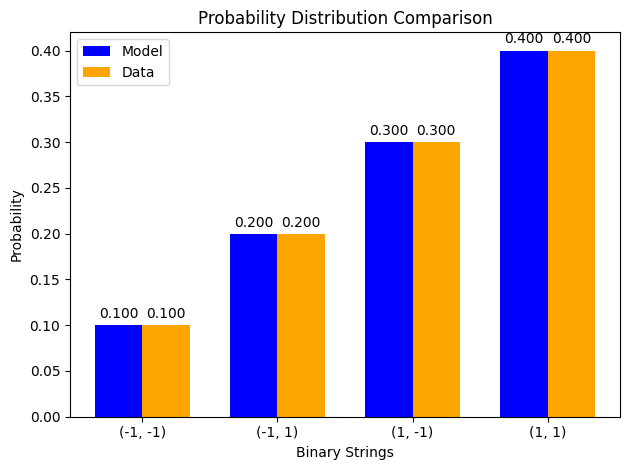

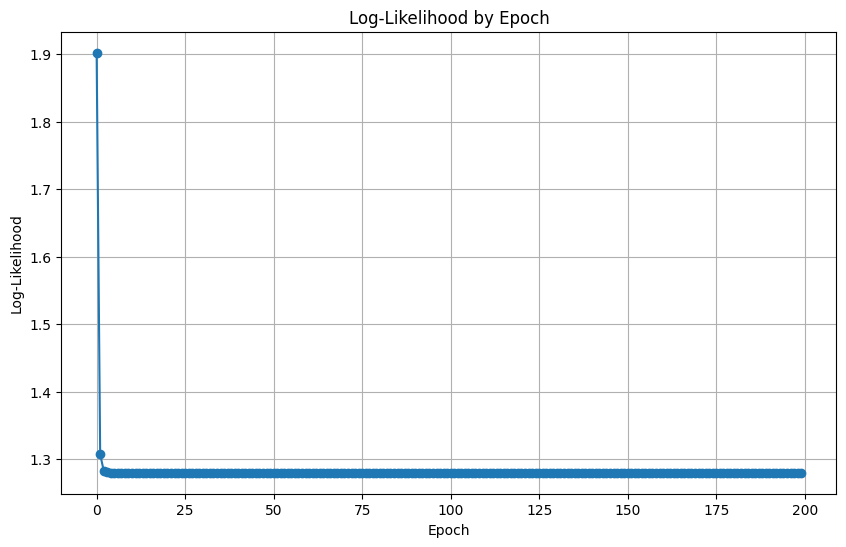

minLLH: (87, 1.2798542258336671)


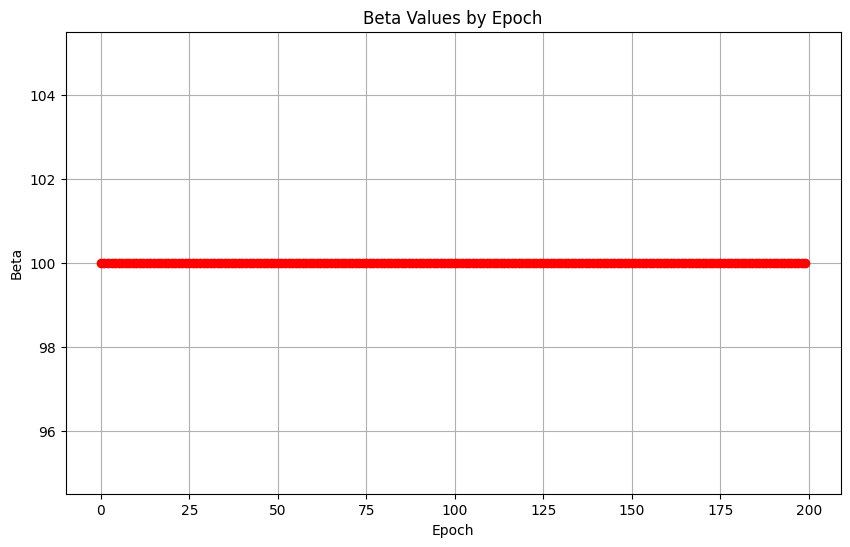

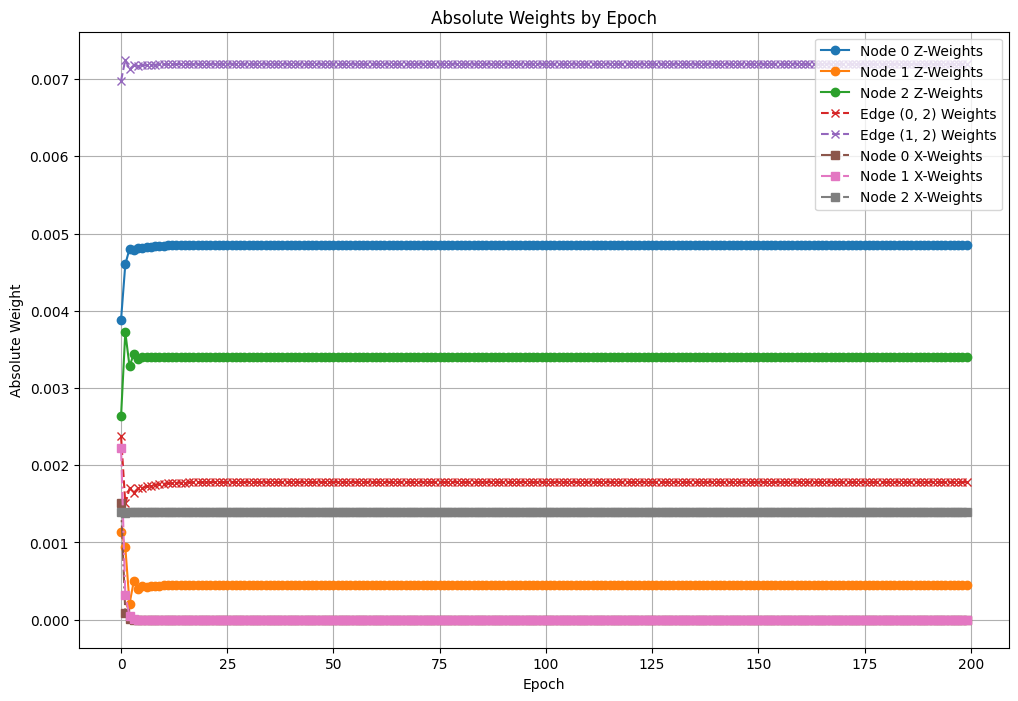

In [10]:
data = [(-1,-1), 
        (-1,1), (-1,1), 
        (1,-1), (1,-1), (1,-1), 
        (1,1), (1,1), (1,1), (1,1)]


qbm = RBM(numInputNodes = 1,
                    numOutputNodes = 1,
                    numHiddenNodes = 1,
                    beta=100,
                    vvEdges=False,
                    qrbm = True, 
                    trainTransverse = True)


qbm.train(data=data,
          optimizer=None,
          alpha=.01,
          epochs=200,
          tempSchedule=None,
          finalBeta=None,
          betaGrowthEpochs=None,
          verbose=False,
          infoEveryNepochs=1)

Results:


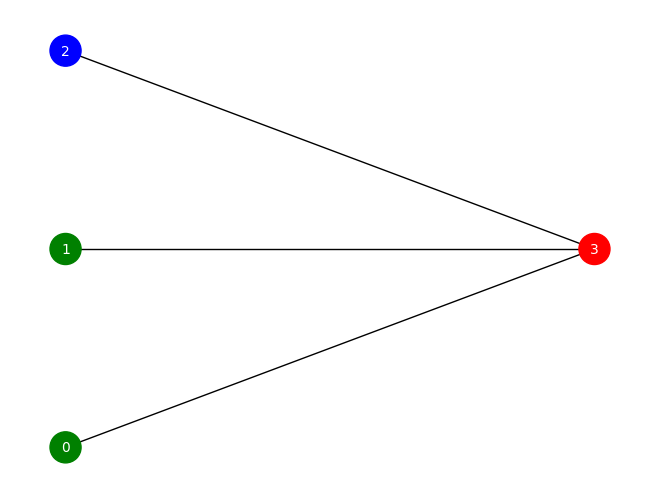

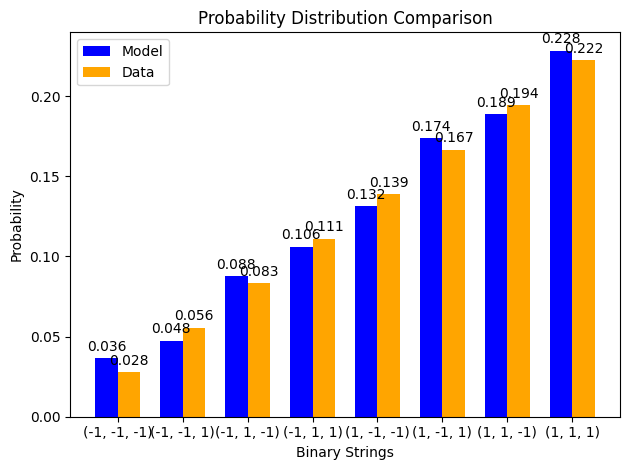

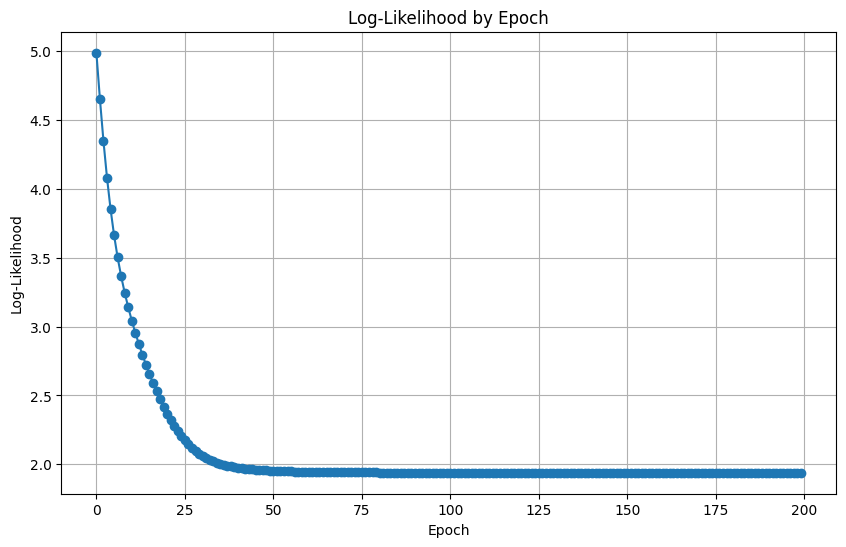

minLLH: (199, 1.9393055435803914)


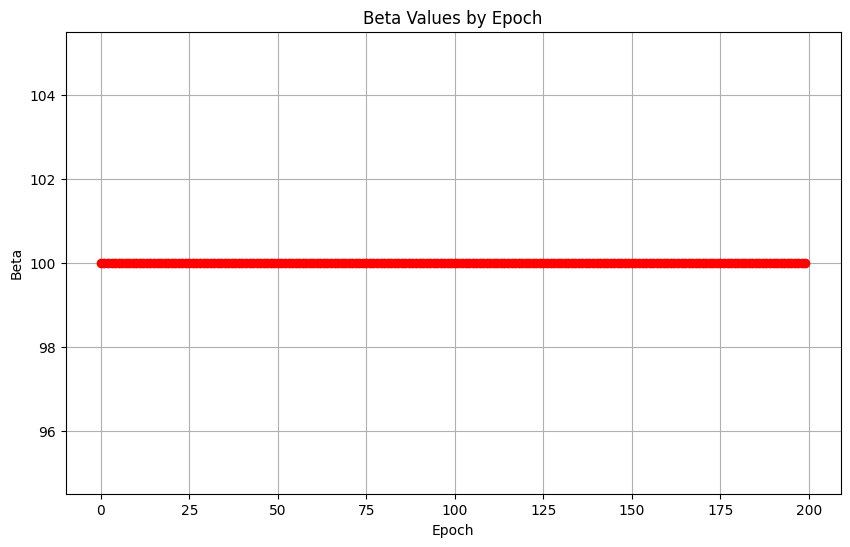

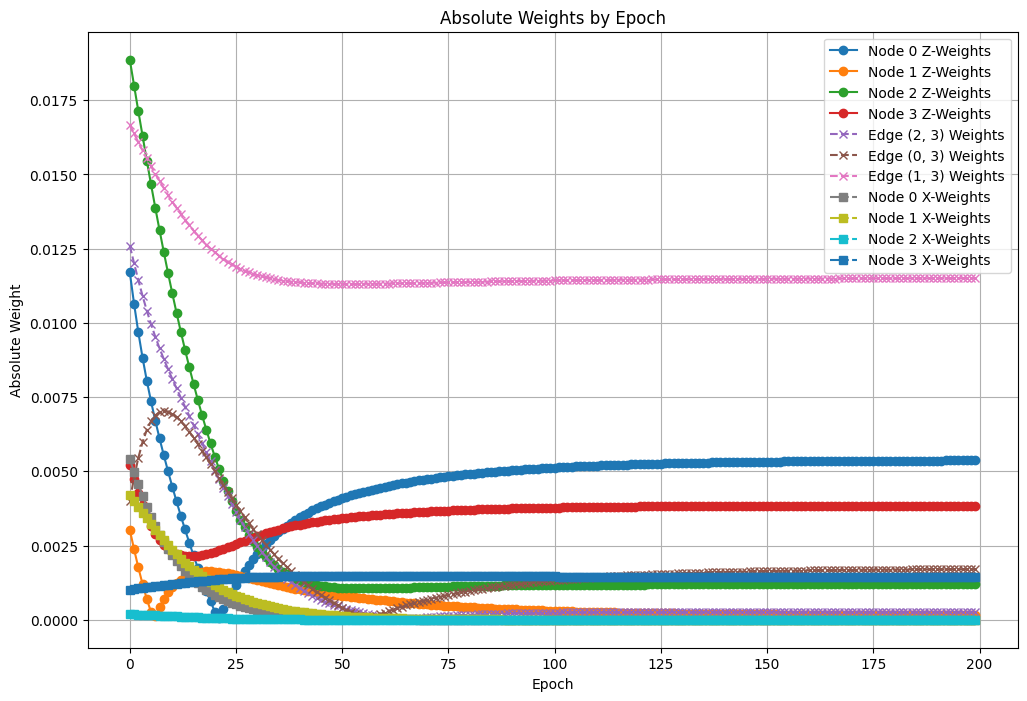

In [14]:
data = [(-1,-1,-1),
        (-1,-1,1), (-1,-1,1),
        (-1,1,-1), (-1,1,-1), (-1,1,-1),
        (-1,1,1), (-1,1,1), (-1,1,1), (-1,1,1),
        (1,-1,-1), (1,-1,-1), (1,-1,-1), (1,-1,-1), (1,-1,-1),
        (1,-1,1), (1,-1,1), (1,-1,1), (1,-1,1), (1,-1,1), (1,-1,1),
        (1,1,-1), (1,1,-1), (1,1,-1), (1,1,-1), (1,1,-1), (1,1,-1), (1,1,-1),
        (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1)]


qbm = RBM(numInputNodes = 2,
                    numOutputNodes = 1,
                    numHiddenNodes = 1,
                    beta=100,
                    vvEdges=False,
                    qrbm = True, 
                    trainTransverse = True)


qbm.train(data=data,
          optimizer=None,
          alpha=.001,
          epochs=200,
          tempSchedule=None,
          finalBeta=None,
          betaGrowthEpochs=None,
          verbose=False,
          infoEveryNepochs=1)